LOADING ZACHARY'S KARATE CLUB NETWORK

Network loaded: 34 nodes, 78 edges

Ground truth split:
  • Mr. Hi's faction: 17 members
  • Officer's faction: 17 members

STARTING ITERATIVE COMMUNITY DETECTION


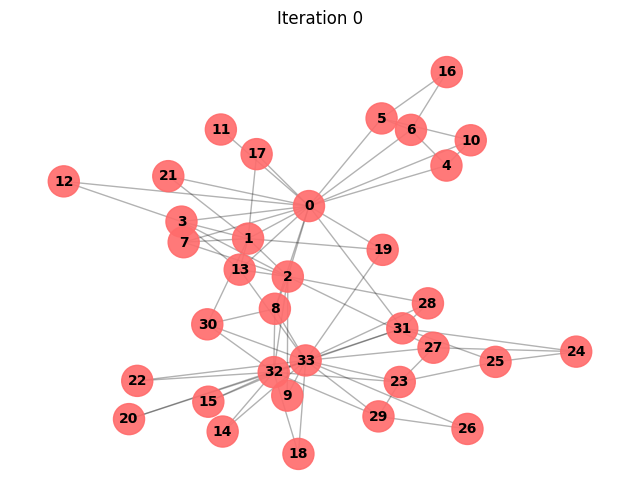

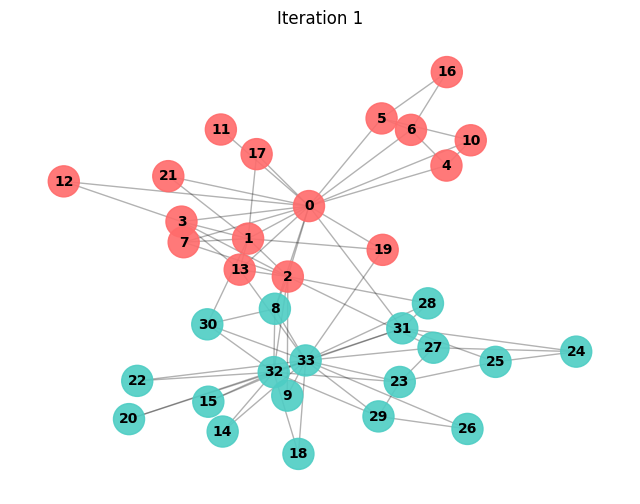

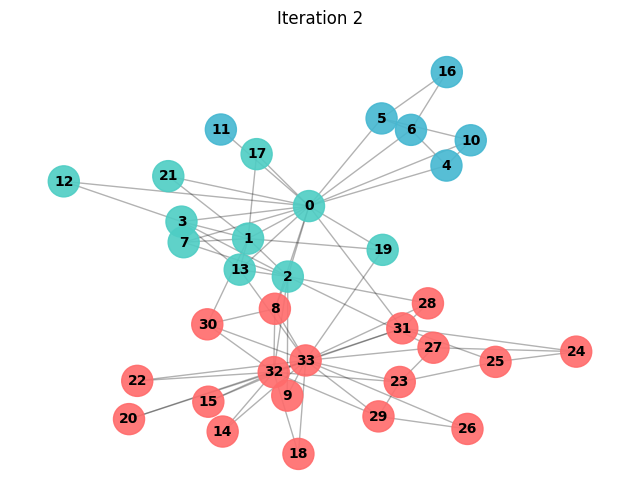


Detection complete after 3 steps.

Final communities found: 3
  Community 1: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  Community 2: [0, 1, 2, 3, 7, 12, 13, 17, 19, 21]
  Community 3: [4, 5, 6, 10, 11, 16]
Final Modularity Q: 0.3898

METRIC EVOLUTION ANALYSIS


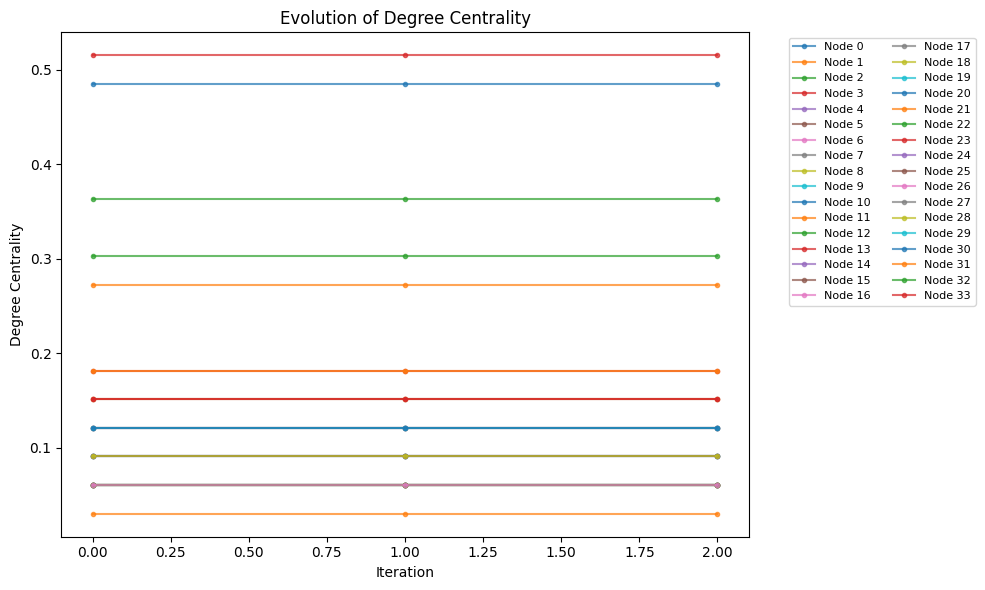

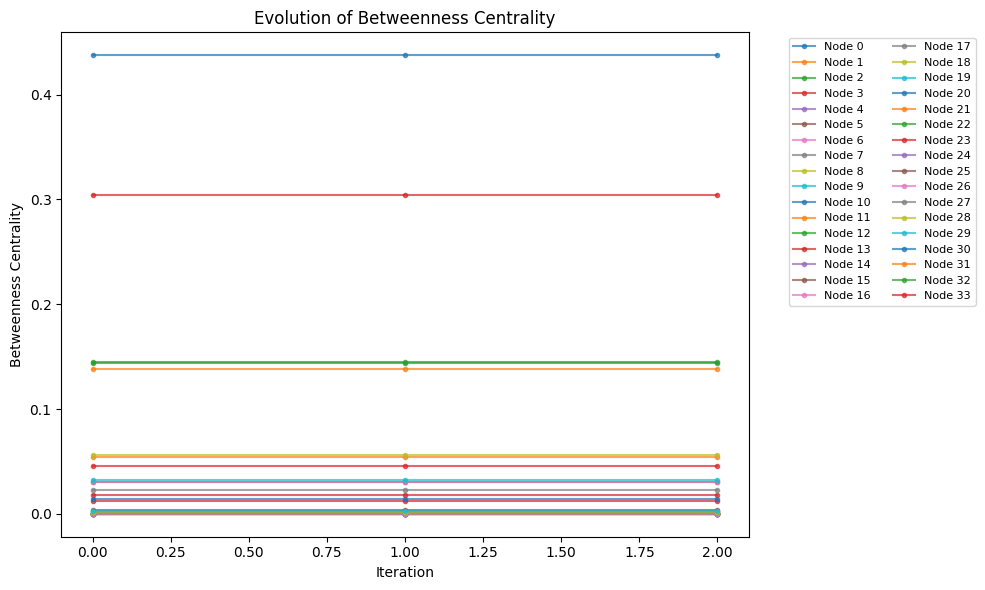

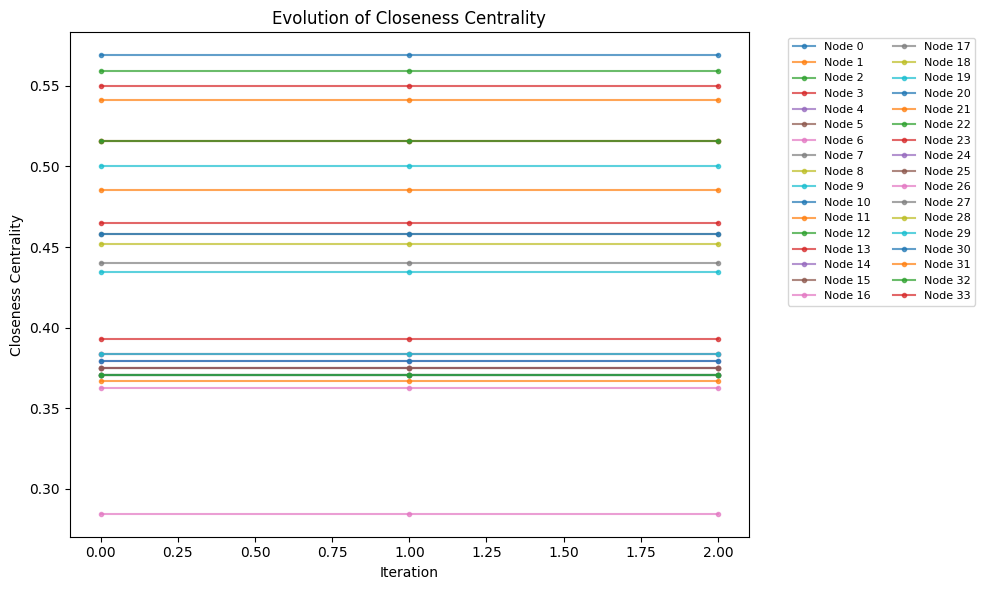

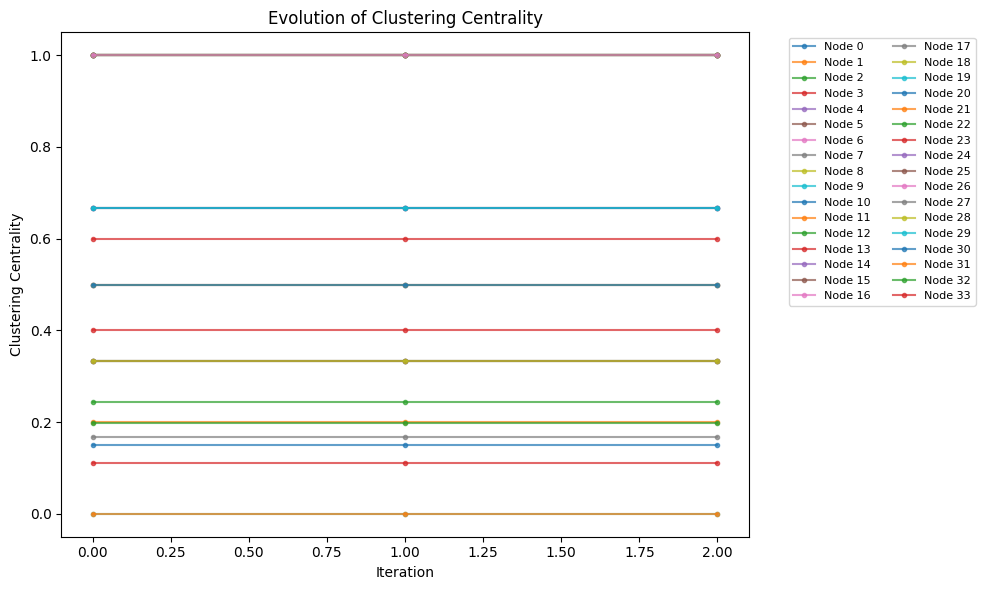


KEY NODE IDENTIFICATION

Top 3 nodes by degree:
  Node 33: 0.5152
  Node 0: 0.4848
  Node 32: 0.3636

Top 3 nodes by betweenness:
  Node 0: 0.4376
  Node 33: 0.3041
  Node 32: 0.1452

Top 3 nodes by closeness:
  Node 0: 0.5690
  Node 2: 0.5593
  Node 33: 0.5500

Top 3 nodes by clustering:
  Node 7: 1.0000
  Node 12: 1.0000
  Node 14: 1.0000

COMPARISON WITH GROUND TRUTH

Accuracy of initial split vs ground truth: 97.06%

Analysis Finished.


In [2]:
# Community Detection in Zachary's Karate Club Graph
# Simplified version for DSC212

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed for consistent results
np.random.seed(42)

# --- Part 1: Load the Graph ---
print("="*70)
print("LOADING ZACHARY'S KARATE CLUB NETWORK")
print("="*70)
G = nx.karate_club_graph()
print(f"\nNetwork loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Ground truth clubs (Mr. Hi and Officer)
ground_truth = {node: G.nodes[node]['club'] for node in G.nodes()}
print(f"\nGround truth split:")
print(f"  • Mr. Hi's faction: {list(ground_truth.values()).count('Mr. Hi')} members")
print(f"  • Officer's faction: {list(ground_truth.values()).count('Officer')} members")

# --- Part 2: Build the Modularity Matrix ---
def build_modularity_matrix(G, nodes=None):
    if nodes is None:
        nodes = list(G.nodes())
    node_list = sorted(nodes)
    n_nodes = len(node_list)

    # Adjacency matrix for current nodes
    A = np.zeros((n_nodes, n_nodes))
    for i, node_i in enumerate(node_list):
        for j, node_j in enumerate(node_list):
            if G.has_edge(node_i, node_j):
                A[i, j] = 1

    # Degrees of nodes in the FULL graph
    degrees = np.array([G.degree(node) for node in node_list])
    m_total = G.number_of_edges()

    # Modularity matrix formula
    null_model = np.outer(degrees, degrees) / (2 * m_total)
    B = A - null_model
    return B, node_list

# --- Part 3: Spectral Bisection ---
def spectral_bisection(B, node_list):
    # Find the largest eigenvalue and its eigenvector
    eigenvalues, eigenvectors = np.linalg.eigh(B)
    lambda_1 = eigenvalues[-1]   # Largest eigenvalue
    u_1 = eigenvectors[:, -1]   # Corresponding eigenvector

    # Split nodes based on the sign of eigenvector entries
    group_positive = [node_list[i] for i in range(len(node_list)) if u_1[i] >= 0]
    group_negative = [node_list[i] for i in range(len(node_list)) if u_1[i] < 0]

    return lambda_1, (group_positive, group_negative)

# --- Calculate Modularity ---
def calculate_modularity(G, communities):
    m = G.number_of_edges()
    Q = 0
    for community in communities:
        for i in community:
            for j in community:
                if G.has_edge(i, j):
                    A_ij = 1
                else:
                    A_ij = 0
                k_i = G.degree(i)
                k_j = G.degree(j)
                Q += A_ij - (k_i * k_j) / (2 * m)
    return Q / (2 * m)

# --- Visualization Function ---
def visualize_communities(G, communities, title, iteration):
    # Generate new layout for each plot
    pos = nx.spring_layout(G, seed=42, k=0.3, iterations=50)
    plt.figure(figsize=(8, 6))

    # Colors for communities
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
    node_colors = {}
    for i, comm in enumerate(communities):
        color = colors[i % len(colors)]
        for node in comm:
            node_colors[node] = color

    # Draw graph
    nx.draw_networkx_nodes(G, pos, node_color=[node_colors[n] for n in G.nodes()], node_size=500, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    plt.title(title)
    plt.axis('off')
    plt.savefig(f'karate_iteration_{iteration}.png')
    plt.show()

# --- Part 5: Recursive Bisection (Removed as it's not used in the iterative approach) ---

# --- Part 6: Iterative Splitting with Tracking ---
print("\n" + "="*70)
print("STARTING ITERATIVE COMMUNITY DETECTION")
print("="*70)

class CommunityTracker:
    def __init__(self, G):
        self.G = G
        self.iteration = 0
        self.history = []

    def compute_metrics(self, communities):
        return {
            'degree': nx.degree_centrality(self.G),
            'betweenness': nx.betweenness_centrality(self.G),
            'closeness': nx.closeness_centrality(self.G),
            'clustering': nx.clustering(self.G)
        }

    def record_state(self, communities):
        non_empty_communities = [c for c in communities if c]
        metrics = self.compute_metrics(non_empty_communities)
        self.history.append({
            'iteration': self.iteration,
            'communities': [list(c) for c in non_empty_communities],
            'metrics': metrics,
            'num_communities': len(non_empty_communities)
        })
        visualize_communities(self.G, non_empty_communities, f"Iteration {self.iteration}", self.iteration)
        self.iteration += 1


tracker = CommunityTracker(G)

# Start with all nodes in one community
current_communities = [list(G.nodes())]
tracker.record_state(current_communities)

queue = [list(G.nodes())]

while queue and tracker.iteration < 3: # Max 3 iterations for simplicity
    group_to_split = queue.pop(0)

    if not group_to_split or len(group_to_split) <= 1:
        continue

    B, node_list = build_modularity_matrix(G, group_to_split)
    lambda_1, (g_pos, g_neg) = spectral_bisection(B, node_list)

    if lambda_1 > 1e-3: # If splitting is good
        current_communities.remove(group_to_split)
        if g_pos: # Add non-empty groups
            current_communities.append(g_pos)
            queue.append(g_pos)
        if g_neg:
            current_communities.append(g_neg)
            queue.append(g_neg)

        tracker.record_state(current_communities)

print(f"\nDetection complete after {tracker.iteration} steps.")

# --- Final Community Structure ---
final_communities = tracker.history[-1]['communities']
print(f"\nFinal communities found: {len(final_communities)}")
for i, comm in enumerate(final_communities, 1):
    print(f"  Community {i}: {sorted(comm)}")

final_Q = calculate_modularity(G, final_communities)
print(f"Final Modularity Q: {final_Q:.4f}")

# --- Part 7: Metric Evolution Analysis ---
print("\n" + "="*70)
print("METRIC EVOLUTION ANALYSIS")
print("="*70)
metric_names = ['degree', 'betweenness', 'closeness', 'clustering']

for metric_name in metric_names:
    plt.figure(figsize=(10, 6))
    for node in G.nodes():
        values = [state['metrics'][metric_name][node] for state in tracker.history]
        iterations = [state['iteration'] for state in tracker.history]
        plt.plot(iterations, values, marker='.', label=f'Node {node}', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel(f'{metric_name.capitalize()} Centrality')
    plt.title(f'Evolution of {metric_name.capitalize()} Centrality')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

# --- Part 8: Identifying Key Nodes ---
print("\n" + "="*70)
print("KEY NODE IDENTIFICATION")
print("="*70)
final_metrics = tracker.history[-1]['metrics']

for metric_name in metric_names:
    values = final_metrics[metric_name]
    sorted_nodes = sorted(values.items(), key=lambda x: x[1], reverse=True)
    print(f"\nTop 3 nodes by {metric_name.replace('_', ' ')}:")
    for node, value in sorted_nodes[:3]:
        print(f"  Node {node}: {value:.4f}")

# --- Comparison with Ground Truth ---
print("\n" + "="*70)
print("COMPARISON WITH GROUND TRUTH")
print("="*70)
B_full, nodes_full = build_modularity_matrix(G)
lambda_1_initial, (group_pos_initial, group_neg_initial) = spectral_bisection(B_full, nodes_full)

our_first_split = [group_pos_initial, group_neg_initial]

mr_hi_nodes = [node for node, club in ground_truth.items() if club == 'Mr. Hi']
officer_nodes = [node for node, club in ground_truth.items() if club == 'Officer']
true_split = [mr_hi_nodes, officer_nodes]

def calculate_accuracy(our_split, true_split, G):
    acc1 = len(set(our_split[0]) & set(true_split[0])) + len(set(our_split[1]) & set(true_split[1]))
    acc2 = len(set(our_split[0]) & set(true_split[1])) + len(set(our_split[1]) & set(true_split[0]))
    return max(acc1, acc2) / len(G.nodes())

accuracy = calculate_accuracy(our_first_split, true_split, G)
print(f"\nAccuracy of initial split vs ground truth: {accuracy:.2%}")

print("\nAnalysis Finished.")